In [3]:
import os
os.chdir('/home/seidi/Repositories/mestrado_final/')
import utils
import numpy as np
import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

mb = utils.read_mb()
mf = utils.read_mf()
not_metafeatures = ['Recall', 'IndexParams', 'QueryTimeParams', 'graph_type', 'k_searching']

# Pearson correlation, where features lie in quantile >= 0.9
pearson_corr = mb.corr().Recall.abs().sort_values(ascending=False)
pearson_corr.drop(not_metafeatures, inplace=True)
pearson_corr[pearson_corr > pearson_corr.quantile(.9)].index
PEARSON_FEATURES = ['lid_mean', 'rv', 'attr_ent.mean', 'min.mean', 'nr_inst']

# PCA evaluation, for the first n features 
# that sum 0.9 of the explained variance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
tmp = mb.copy()
sc = StandardScaler()
tmp.loc[:,:] = sc.fit_transform(tmp)

pca = PCA()
pca.fit(tmp.values)
xvar = pd.DataFrame({
    'ratio': np.abs(pca.explained_variance_ratio_),
    'feature': tmp.columns
}).sort_values(by='ratio', ascending=False)

var_sum = 0
for ix, f in enumerate(xvar.feature.unique()):
    var_sum += xvar[xvar.feature==f].ratio.values[0]
    if var_sum >= .95:
        PCA_FEATURES = xvar.head(ix)[~xvar.feature.isin(not_metafeatures)].feature.values
        break

# RF importance, where features lie in quantile >= 0.9
fi = pd.read_csv('data/feature_importances.csv')
fi.importance = fi.importance/fi.importance.sum()
RF_FEATURES= fi[fi.importance >= fi.importance.quantile(.9)].feature.values


# Measuring similarity according each fs method
fs_methods = {
    # 'pearson': PEARSON_FEATURES,
    # 'pca': PCA_FEATURES,
    'rf': RF_FEATURES
}

out = dict()
for key, array in fs_methods.items():
    out[key] = utils.get_similar(mf, array)

In [28]:
print(*out['rf'].items(), sep='\n')

('texture_67940', array(['moments_67940', 'moments_64000', 'moments_32000', 'moments_16000',
       'colorHisto_67940'], dtype=object))
('sift_999900', array(['base31_99900', 'base40_99900', 'base31_64000', 'base60_999900',
       'base69_999900'], dtype=object))
('moments_67940', array(['colorHisto_67940', 'colorHisto_64000', 'colorHisto_32000',
       'colorHisto_16000', 'base59_999900'], dtype=object))
('mnist121d_69900', array(['fashion_32000', 'fashion_64000', 'fashion_69900', 'mnist_69900',
       'fashion_16000'], dtype=object))
('fashion_69900', array(['mnist121d_69900', 'mnist121d_64000', 'mnist121d_32000',
       'colorHisto_32000', 'colorHisto_16000'], dtype=object))
('colorHisto_67940', array(['moments_32000', 'moments_64000', 'moments_67940', 'moments_16000',
       'base28_32000'], dtype=object))
('mnist_69900', array(['mnist121d_32000', 'mnist121d_64000', 'mnist121d_69900',
       'mnist121d_16000', 'fashion_16000'], dtype=object))


<AxesSubplot:xlabel='Distance', ylabel='Count'>

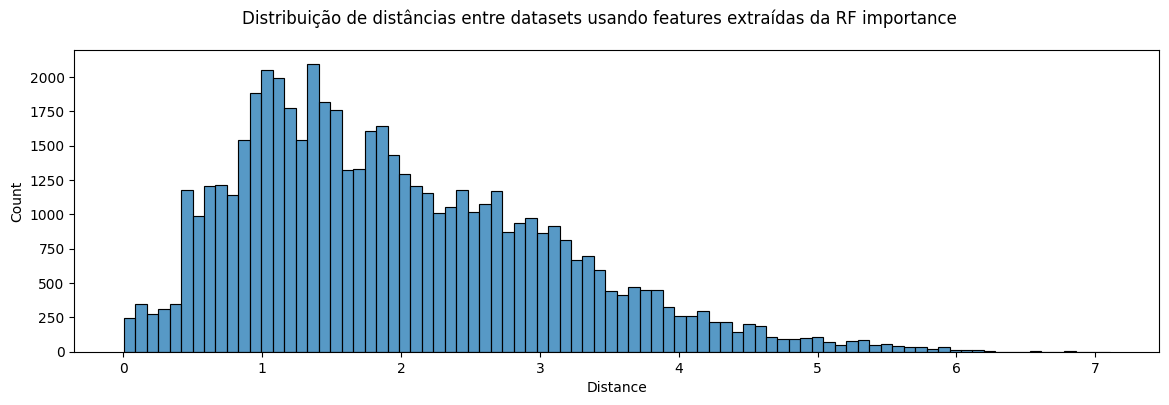

In [92]:
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
mf_new = mf[RF_FEATURES].copy()
sc = StandardScaler()
sc.fit(mf_new)
mf_new.loc[:, :] = sc.transform(mf_new)

knng = NearestNeighbors(n_neighbors=mf_new.shape[0])
knng.fit(mf_new)
dist, ix = knng.kneighbors(mf_new)
dist = dist[:, 1:]
lt_dist = dist[np.tril_indices(dist.shape[0], -1)]
plt.figure(figsize=(14,4), dpi=100)
plt.suptitle('Distribuição de distâncias entre datasets usando features extraídas da RF importance')
plt.xlabel('Distance')
sns.histplot(lt_dist)

In [101]:
import scipy.stats as sp

# print("Medidas estatísticas extraídas do vetor de distâncias")
# print(f'Mean={np.mean(lt_dist):.2f}')
# print(f'Median={np.median(lt_dist):.2f}')
# print(f'Std={np.std(lt_dist):.2f}')
# print(f'Min={np.min(lt_dist):.2f}')
# print(f'Max={np.max(lt_dist):.2f}')
# print(f'Entropy={sp.entropy(lt_dist):.2f}')
# print(f'Skew={sp.skew(lt_dist):.2f}')
# print(f'Kurtosis={sp.kurtosis(lt_dist):.2f}')
print(f'Q1={np.quantile(lt_dist, 0.05):.2f}')
# print(f'Q2={np.quantile(lt_dist, 0.5):.2f}')
# print(f'Q3={np.quantile(lt_dist, 0.75):.2f}')


Q1=0.50


<AxesSubplot:xlabel='k-neighbors', ylabel='Mean distances'>

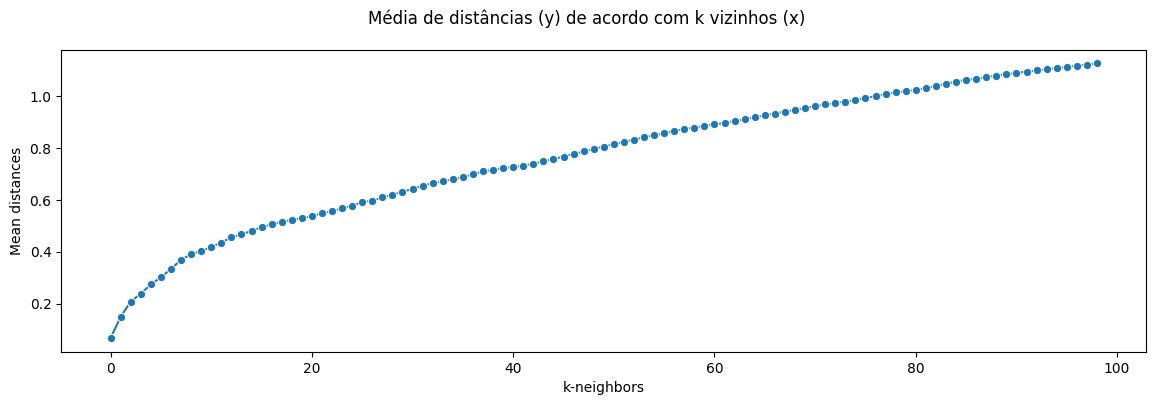

In [108]:
dists = []
for k in range(1, 100):
    knng = NearestNeighbors(n_neighbors=k+1)
    knng.fit(mf_new)
    dist, ix = knng.kneighbors(mf_new)
    dist = dist[:, 1:]
    dists.append(np.median(np.mean(dist, axis=1)))


# sns.histplot(dists)
plt.figure(figsize=(14,4), dpi=100)
plt.suptitle('Média de distâncias (y) de acordo com k vizinhos (x)')
plt.ylabel('Mean distances')
plt.xlabel('k-neighbors')
sns.lineplot(np.arange(len(dists)), dists, marker='o')

In [137]:
dists[0:5]
plt.style.use('bmh')


In [146]:
print(np.hist(dist, 10))

AttributeError: module 'numpy' has no attribute 'hist'

0.3770623950296368


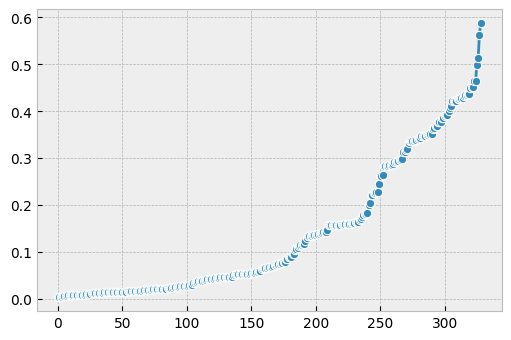

In [149]:
knng = NearestNeighbors(n_neighbors=2)
knng.fit(mf_new)
dist, ix = knng.kneighbors(mf_new)
dist = dist[:, 1:].reshape(-1)
dist = np.sort(dist)
plt.figure(figsize=(6,4), dpi=100)
sns.lineplot(np.arange(len(dist)), dist, marker='o')
print(np.quantile(dist, 0.9))

Text(0.5, 0, 'k')

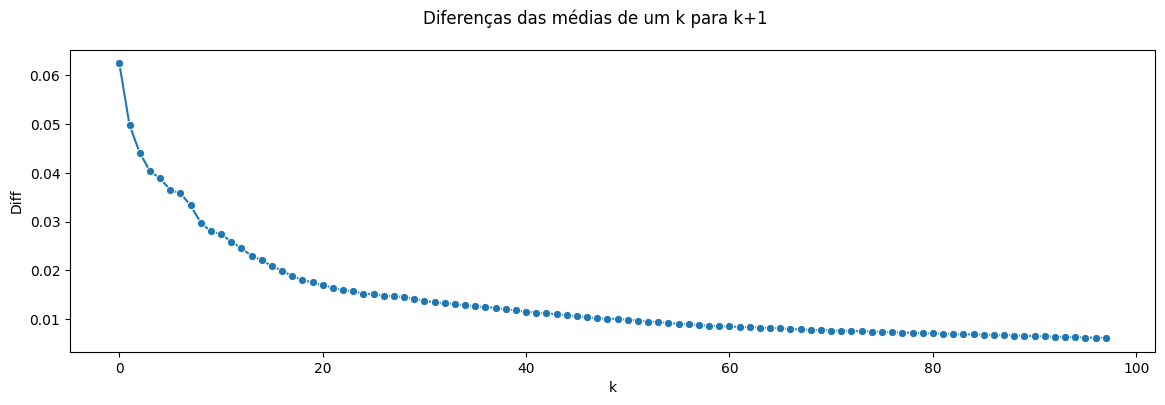

In [90]:
diffs = []
for ix, v in enumerate(dists):
    # print(f'({ix+1})-({ix}) = {dists[ix+1] - dists[ix]}')
    if ix == len(dists)-1:
        break
    diffs.append(dists[ix+1] - dists[ix])

plt.figure(figsize=(14,4), dpi=100)
plt.suptitle('Diferenças das médias de um k para k+1')
sns.lineplot(np.arange(len(diffs)), diffs, marker='o')
plt.ylabel('Diff')
plt.xlabel('k')